# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*

**Estimated time:** XX mins presenting + YY mins exercises

## Chapter 3: Image Processing

<font color=red>
USE https://bioimagebook.github.io/chapters/2-processing/1-processing_and_analysis/processing_and_analysis.html
</font>

<font face=blue>
### Some notes to self beforehand

- Image processing vs. image analysis
- Point vs. neighborhood operations

</font>

## Adjusting contrast

When looking at an image you might see striking features, and think that's all your looking at.

However, both for humans looking at pictures, and for computers analyzing pictures, features can remain depending on display or processing.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
import numpy as np

# some new ones
import skimage as sk
from scipy import stats
from scipy import ndimage

# something convenient for later
FIGSIZE21 = (10/2.54,5/2.54) 
FIGSIZE22 = (10/2.54,10/2.54) 

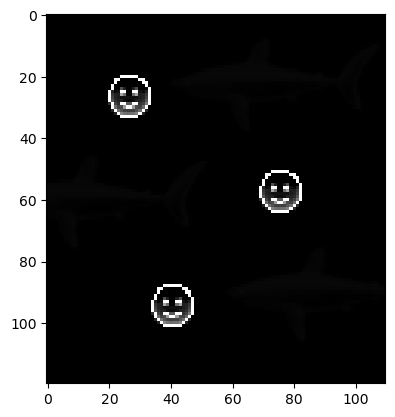

In [3]:
# Let's say we're investigating marine microogranism E. moji, 
# and we've taken the microscopy image below.

image_path = 'images/emoji/emojis-swimming.tif'
img_emoji = tiff.imread(image_path)

# And now we're displaying the image:
_ = plt.imshow(img_emoji, cmap='grey')

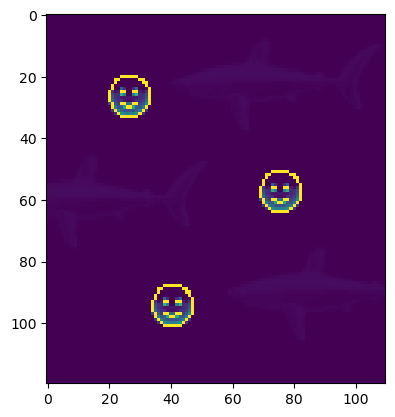

In [4]:
# Great! Three specimen are swimming around happily!

# But wait..
_ = plt.imshow(img_emoji, cmap='viridis')

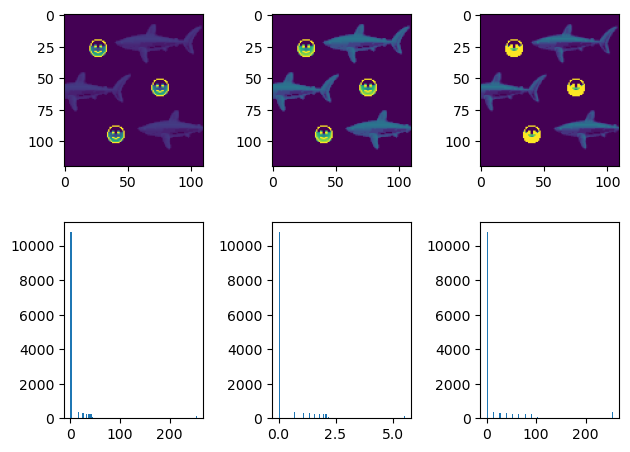

In [5]:
# The viridis colormap shows us there might be some more signal. 

# (You can also try to open this image in FIJI, and play around with contrast.)

# There appears to be an import signal in the low range
#   "high dynamic range"

# For visual inspection, let's

fig, axs = plt.subplots(2,3)
# Apply gamma transformation
img_emoji_gamma = sk.exposure.adjust_gamma(img_emoji, gamma=0.5)
_ = axs[0,0].imshow(img_emoji_gamma)
# Use a simple log
img_emoji_log = np.log(1+img_emoji/255*254)
_ = axs[0,1].imshow(img_emoji_log)
# Normalize the image by 20
img_emoji_norm = img_emoji.copy()
img_emoji_norm[img_emoji_norm>20] = 20
img_emoji_norm = img_emoji_norm/20*255
_ = axs[0,2].imshow(img_emoji_norm)
#_ = axs[2].imshow(sk.exposure.adjust_gamma(img_emoji, gamma=2.0))

# Show the corresponding histograms
_ = axs[1,0].hist(img_emoji_gamma.ravel(), bins=100)
_ = axs[1,1].hist(img_emoji_log.ravel(), bins=100)
_ = axs[1,2].hist(img_emoji_norm.ravel(), bins=100)

plt.tight_layout()

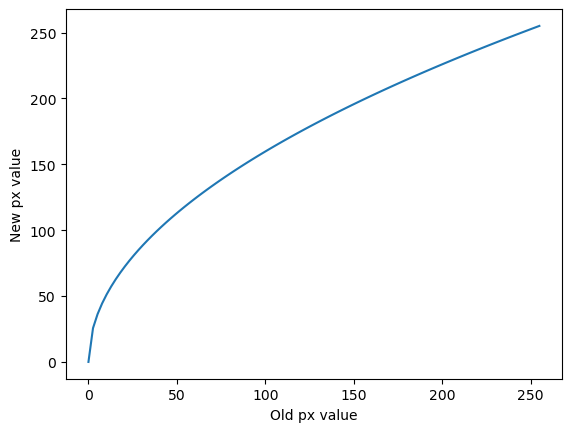

In [6]:
# Show the gamma input/output relation
x = np.linspace(0,255,100)
x_transformed = sk.exposure.adjust_gamma(x, gamma=0.5)
x_transformed_255 = x_transformed/np.max(x_transformed)*255

fig, ax = plt.subplots()
_ = ax.plot(x, x_transformed_255,
                label='gamma=0.5')
_ = ax.set_xlabel('Old px value')
_ = ax.set_ylabel('New px value')

Note that these operations **won't magically put new information** into the picture. But they can be really usefull for **visualization** purposes. Especially **combined with histograms**.

## Segmentation (1)

Segmentation is a prime example of image processing usful for biologists.

Say you want to 
- quantify bacterial growth, 
- take measurements on individual cultured cells, 
- or quantify leaf damage, 

the computer will have to understand **which pixel belongs to which cell** to quantify anything.

In later sections, we'll look at **how to process these annotated regions**.

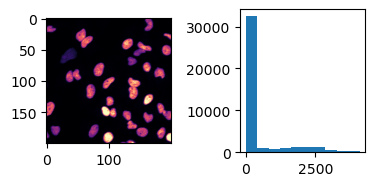

In [7]:
# Let's load some nuclei example data again
img_path_KTR = '/Users/m.wehrens/Data_notbacked/2025_Py-Image-workshop_KTR-example-data/raw/Composite_KTR.tif'
img_nuclei = tiff.imread(img_path_KTR)[0, 0, 0:200, 0:200]

fig, axs = plt.subplots(1,2, figsize=FIGSIZE21)
_ = axs[0].imshow(img_nuclei, cmap='magma')
_ = axs[1].hist(img_nuclei.ravel())
plt.tight_layout()

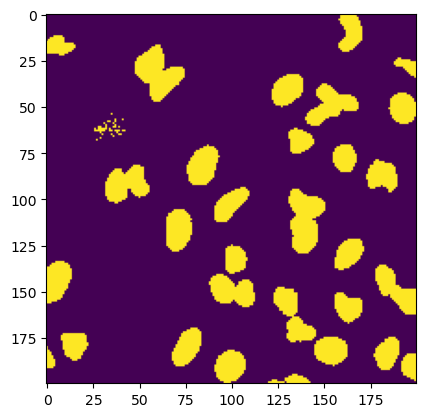

In [8]:
# A simple *manual* threshold mask suffices
mask_nuclei = img_nuclei>700
_=plt.imshow(mask_nuclei)

### Looking into statistics

We'll progress to somewhat more realistic examples later, but let's say we want to **quantify the size of the nuclei**.

This requires some more tools.

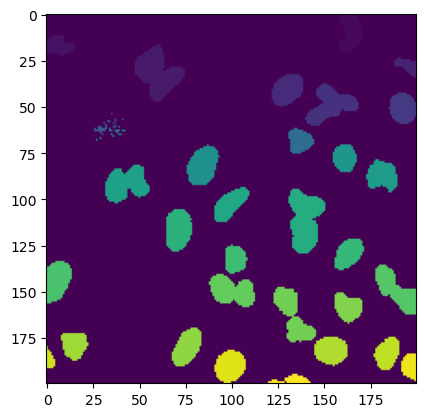

In [9]:
# label the nuclei
labeled_nuclei = sk.measure.label(mask_nuclei)
_ = plt.imshow(labeled_nuclei)

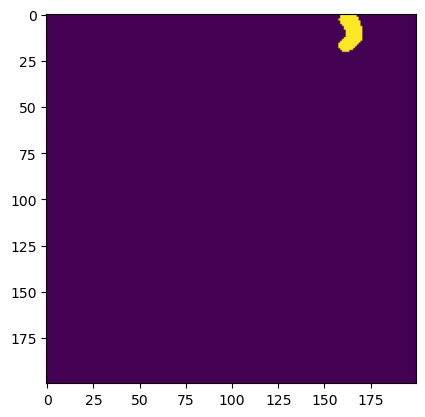

In [10]:
# The labeled map is a great tool for inspecting object properties
_ = plt.imshow(labeled_nuclei==1)

[198 123 455  71 230 336 200   1   6   1]


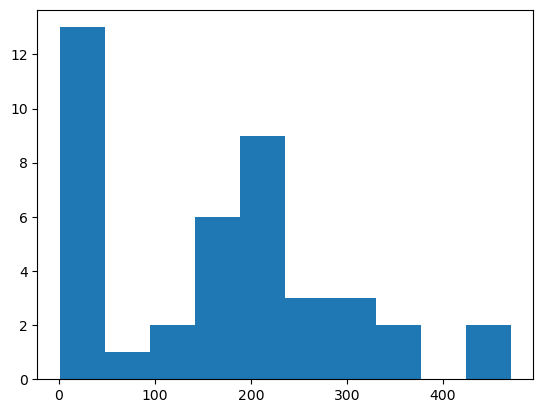

In [11]:
# Similarly we can count the sizes
nuclei_sizes = np.array([np.sum(labeled_nuclei==label) 
                         for label in range(1,np.max(labeled_nuclei))])
print(nuclei_sizes[0:10])

# and show the histogram
_ = plt.hist(nuclei_sizes)


In [12]:
# There are functions that make such tasks much easier

# Let's get regionprops
regions = sk.measure.regionprops(labeled_nuclei, intensity_image=img_nuclei)

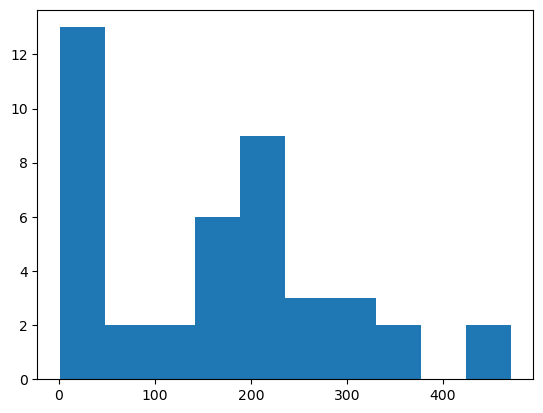

In [13]:
# Let's inspect a region object
region_1 = regions[0]

# What kind of things are stored in here?
# For more info, see:
# https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#skimage.measure.regionprops

region_1.area
region_1.bbox
region_1.centroid

# And we can easily make the histogram, using:
areas = [r.area for r in regions]
_=plt.hist(areas)


## Exercises part I

#### E. moji
- Try to segment the "E. moji" image, both the *E. mojis* and the other organism (*S. hark*?) that's present.
- Make a histogram of the object sizes.
- Why does the histogram look the way it looks?

#### Nuclei
- We made a histogram of nuclear sizes, but the sizes were in pixels. Produce a histogram with the sizes in microns. (You might need a tool like FIJI.)
- Let's also make a more fancier plot:
    - Can you also add their contours?
    - And put a cross in their centers?
    - **[Optional]** Use the functions `np.random.rand()` and `ListedColormap()` to create a colormap that's a bit more useful to display the labeled nuclei.
    
#### (Optional) Dodgy guys
- Load the picture `images/car/dodgy-guys.tif`
    - Can you count the amount of dodgy guys with python?
    - Can you identify where they are in the image (put a cross in a plot)?
    - Can you put the sizes of each of the heads on top of their heads in a plot?
    - Can you now easily spot which of the faces only occurs once in this image?